In [1]:


import numpy as np
from keras.layers import Input, Dense, Lambda
from keras.layers.merge import concatenate as concat
from keras.models import Model
from keras import backend as K
from keras.datasets import mnist
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
X_train = X_train.astype('float32') / 255.
X_test = X_test.astype('float32') / 255.
print(X_test.shape)

n_pixels = np.prod(X_train.shape[1:])
X_train = X_train.reshape((len(X_train), n_pixels))
X_test = X_test.reshape((len(X_test), n_pixels))
print(n_pixels)

(10000, 28, 28)
784


In [4]:
y_train = to_categorical(Y_train)
y_test = to_categorical(Y_test)

In [5]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], dtype=float32)

In [37]:
m = 250 # batch size
n_z = 10 # latent space size
encoder_dim1 = 512 # dim of encoder hidden layer
decoder_dim = 512 # dim of decoder hidden layer
decoder_out_dim = 784 # dim of decoder output layer
activ = 'relu'
optim = Adam(lr=0.001)


n_x = X_train.shape[1]
n_y = y_train.shape[1]


n_epoch = 50

In [38]:

X = Input(shape=(n_x,))
label = Input(shape=(n_y,))

In [39]:
inputs = concat([X, label])

In [40]:
encoder_h = Dense(encoder_dim1, activation=activ)(inputs)
mu = Dense(n_z, activation='linear')(encoder_h)
l_sigma = Dense(n_z, activation='linear')(encoder_h)

In [41]:
def sample_z(args):
    mu, l_sigma = args
    eps = K.random_normal(shape=(m, n_z), mean=0., stddev=1.)
    return mu + K.exp(l_sigma / 2) * eps


# Sampling latent space
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

In [42]:
z = Lambda(sample_z, output_shape = (n_z, ))([mu, l_sigma])

# merge latent space with label
zc = concat([z, label])

In [43]:
decoder_hidden = Dense(decoder_dim, activation=activ)
decoder_out = Dense(decoder_out_dim, activation='sigmoid')
h_p = decoder_hidden(zc)
outputs = decoder_out(h_p)

In [44]:

def vae_loss(y_true, y_pred):
    recon = K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)
    kl = 0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=-1)
    return recon + kl

def KL_loss(y_true, y_pred):
	return(0.5 * K.sum(K.exp(l_sigma) + K.square(mu) - 1. - l_sigma, axis=1))

def recon_loss(y_true, y_pred):
	return K.sum(K.binary_crossentropy(y_true, y_pred), axis=-1)

In [45]:
cvae = Model([X, label], outputs)




In [46]:

cvae.compile(optimizer=optim, loss=vae_loss, metrics = [KL_loss, recon_loss,'acc'])

In [47]:
cvae_hist = cvae.fit([X_train, y_train], X_train, verbose = 1, batch_size=m, epochs=n_epoch,
							validation_data = ([X_test, y_test], X_test),
							callbacks = [EarlyStopping(patience = 5)])

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 3s 45us/step - loss: 182.8263 - KL_loss: 14.1918 - recon_loss: 168.6344 - acc: 0.0113 - val_loss: 137.7434 - val_KL_loss: 14.6398 - val_recon_loss: 123.1036 - val_acc: 0.0085
Epoch 2/50
60000/60000 [==============================] - 2s 40us/step - loss: 130.9380 - KL_loss: 14.5654 - recon_loss: 116.3726 - acc: 0.0115 - val_loss: 123.9672 - val_KL_loss: 14.8884 - val_recon_loss: 109.0788 - val_acc: 0.0130
Epoch 3/50
60000/60000 [==============================] - 2s 40us/step - loss: 121.9201 - KL_loss: 14.7467 - recon_loss: 107.1734 - acc: 0.0121 - val_loss: 118.2156 - val_KL_loss: 14.7783 - val_recon_loss: 103.4372 - val_acc: 0.0142
Epoch 4/50
60000/60000 [==============================] - 2s 40us/step - loss: 117.4796 - KL_loss: 14.9694 - recon_loss: 102.5102 - acc: 0.0124 - val_loss: 114.7557 - val_KL_loss: 15.0998 - val_recon_loss: 99.6559 - val_acc: 0.0120
Epoch 5/50
60000/60

In [48]:

def construct_numvec(digit, z = None):
    out = np.zeros((1, n_z + n_y))
    out[:, digit + n_z] = 1.
    if z is None:
        return(out)
    else:
        for i in range(len(z)):
            out[:,i] = z[i]
        return(out)
    
sample_3 = construct_numvec(3)
print(sample_3)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


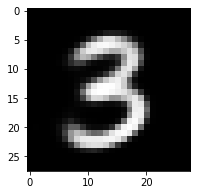

In [49]:
d_in = Input(shape=(n_z+n_y,))
# decoder_hidden = Dense(decoder_dim, activation=activ)
# decoder_out = Dense(decoder_out_dim, activation='sigmoid')
d_h = decoder_hidden(d_in)
d_out = decoder_out(d_h)
decoder = Model(d_in, d_out)
plt.figure(figsize=(3, 3))
plt.imshow(decoder.predict(sample_3).reshape(28,28), cmap = plt.cm.gray)
plt.show()

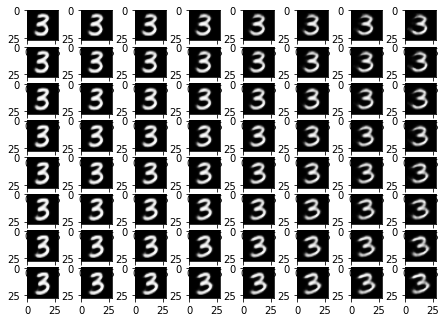

In [50]:
import matplotlib
dig = 3
sides = 8
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        matplotlib.pyplot.subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()

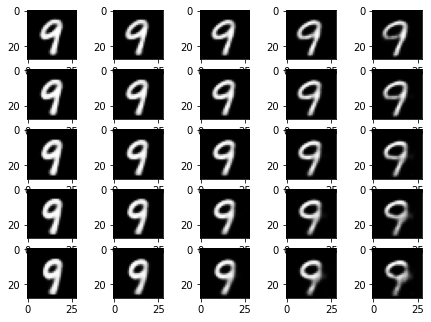

In [51]:
dig = 9
sides = 5
max_z = 1.5

img_it = 0
for i in range(0, sides):
    z1 = (((i / (sides-1)) * max_z)*2) - max_z
    for j in range(0, sides):
        z2 = (((j / (sides-1)) * max_z)*2) - max_z
        z_ = [z1, z2]
        vec = construct_numvec(dig, z_)
        decoded = decoder.predict(vec)
        matplotlib.pyplot.subplot(sides, sides, 1 + img_it)
        img_it +=1
        plt.imshow(decoded.reshape(28, 28), cmap = plt.cm.gray)
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=.2)
plt.show()